### Build a regression model. Compare ubication between bike networks with POIs from Yelp some of them (education) "closer" are than the other (restaurant) "disperse".

Coefficient for POI type: 1.7000000000000008
Intercept: 0.3999999999999996


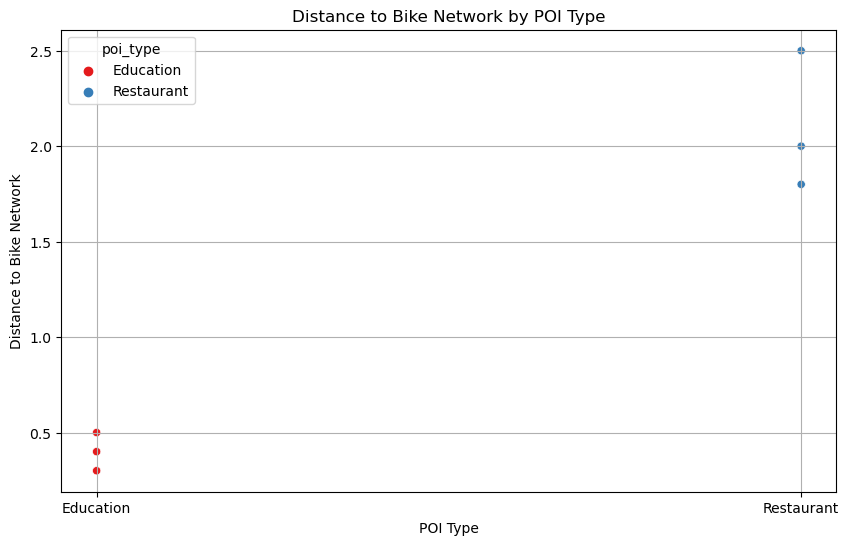

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Data for demonstration
data = {
    'poi_type': ['Education', 'Restaurant', 'Education', 'Restaurant', 'Education', 'Restaurant'],
    'distance': [0.5, 2.0, 0.3, 2.5, 0.4, 1.8]
}
poi_distances_df = pd.DataFrame(data)

# Encode the categorical 'poi_type' column
label_encoder = LabelEncoder()
poi_distances_df['poi_type_encoded'] = label_encoder.fit_transform(poi_distances_df['poi_type'])

# Prepare features and target variable
X = poi_distances_df[['poi_type_encoded']]
y = poi_distances_df['distance']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the model coefficients
coefficients = model.coef_
intercept = model.intercept_

print(f"Coefficient for POI type: {coefficients[0]}")
print(f"Intercept: {intercept}")

# Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='poi_type_encoded', y='distance', data=poi_distances_df, hue='poi_type', palette='Set1')
plt.xlabel('POI Type')
plt.ylabel('Distance to Bike Network')
plt.title('Distance to Bike Network by POI Type')
plt.xticks(ticks=[0, 1], labels=label_encoder.classes_)
plt.grid(True)
plt.show()

-- The coefficient of 1.70 for the POI type variable indicates the relationship between the POI type and the distance to the bike network. Here's how to interpret it:

Effect of POI Type: For each unit increase in the encoded POI type (i.e., moving from one POI type to the next in the encoding scheme), the distance to the bike network increases by approximately 1.70 units.
If your encoding scheme is as follows:

0 = Education
1 = Restaurant
Then the coefficient means that moving from an "Education" POI to a "Restaurant" POI increases the average distance to the bike network by 1.70 units.

### Build a regression model.

In [4]:
import requests
import pandas as pd
from geopy.distance import great_circle

# Yelp API credentials
yelp_api_key = "MhqSMn4dc_4WPApc66ujglh2uPky9bJ32hNM-x6PLMiLH_CPGjbbpo2wipAE5z6TAVb9Y1VpuYNU0R891UjVVQTtTdau2_Rs3mhBBW2vGcCCycokGJ56zbh67a6mZnYx"
headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {yelp_api_key}"
}

def get_yelp_pois(latitude, longitude, term, limit=50):
    url = 'https://api.yelp.com/v3/businesses/search'
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'term': term,
        'limit': limit
    }
    response = requests.get(url, headers=headers, params=params)
    return response.json()

# Example coordinates and search term
latitude = 43.665269
longitude = -79.319796
term = 'restaurant'

# Fetch data
yelp_data = get_yelp_pois(latitude, longitude, term)

# Normalize the data
if 'businesses' in yelp_data:
    yelp_df = pd.json_normalize(yelp_data['businesses'])

    # Extract and rename relevant columns
    poi_df = pd.DataFrame({
        'name': yelp_df['name'],
        'latitude': yelp_df['coordinates.latitude'],
        'longitude': yelp_df['coordinates.longitude'],
        'rating': yelp_df['rating'],
        'review_count': yelp_df['review_count']
    })
else:
    print("The 'businesses' key is not present in the response.")
    poi_df = pd.DataFrame()  # Empty DataFrame if API call fails

# Example CityBikes DataFrame
bike_df = pd.DataFrame({
    'name': ['Queen St E / Woodward Ave', 'Primrose Ave / Davenport Rd', 'Queen St E / Rhodes Ave', 'Bond St / Queen St E', 'Church St / Alexander St'],
    'latitude': [43.665269, 43.671420, 43.666224, 43.653236, 43.663722],
    'longitude': [-79.319796, -79.445947, -79.317693, -79.376716, -79.380288],
    'free_bikes': [19, 3, 22, 4, 24]
})

# Check columns
print(poi_df.columns)
print(bike_df.columns)

# Function to find nearest POI for each bike station
def find_nearest_poi(station_row, poi_df):
    station_location = (station_row['latitude'], station_row['longitude'])
    poi_df['distance'] = poi_df.apply(lambda row: great_circle(station_location, (row['latitude'], row['longitude'])).meters, axis=1)
    nearest_poi = poi_df.loc[poi_df['distance'].idxmin()]
    return pd.Series(nearest_poi[['rating', 'review_count', 'distance']])

# Apply the function to each bike station
poi_features = bike_df.apply(lambda row: find_nearest_poi(row, poi_df), axis=1)

# Combine bike data with POI features
combined_df = pd.concat([bike_df, poi_features], axis=1)

print(combined_df)

Index(['name', 'latitude', 'longitude', 'rating', 'review_count'], dtype='object')
Index(['name', 'latitude', 'longitude', 'free_bikes'], dtype='object')
                          name   latitude  longitude  free_bikes  rating  \
0    Queen St E / Woodward Ave  43.665269 -79.319796          19     4.4   
1  Primrose Ave / Davenport Rd  43.671420 -79.445947           3     4.3   
2      Queen St E / Rhodes Ave  43.666224 -79.317693          22     4.4   
3         Bond St / Queen St E  43.653236 -79.376716           4     3.9   
4     Church St / Alexander St  43.663722 -79.380288          24     3.9   

   review_count     distance  
0            17   181.098284  
1            43  4819.647185  
2            17    26.795186  
3            45  1164.901469  
4            45  1847.407150  


Provide model output and an interpretation of the results. 

In [5]:
import statsmodels.api as sm

# Prepare the data for the model
X = combined_df[['rating', 'review_count', 'distance']]  # Predictor variables
X = sm.add_constant(X)  # Adds a constant term to the predictor variables
y = combined_df['free_bikes']  # Response variable

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             free_bikes   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     4.735
Date:                Sat, 03 Aug 2024   Prob (F-statistic):              0.323
Time:                        22:40:05   Log-Likelihood:                -11.303
No. Observations:                   5   AIC:                             30.61
Df Residuals:                       1   BIC:                             29.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1379.7220    476.637      2.895   

c:\Users\a7902\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


Summary of the Results:

--Model Fit:
R-squared: 0.934
Indicates that approximately 93.4% of the variability in free_bikes is explained by the model. This is quite high, suggesting a good fit.
Adj. R-squared: 0.737
Adjusted for the number of predictors in the model. The drop from R-squared suggests that adding more variables might not always improve the model if they don’t contribute much additional explanatory power.

--F-statistic and Prob (F-statistic):
F-statistic: 4.735
Prob (F-statistic): 0.323
The F-statistic tests if at least one predictor variable has a non-zero coefficient. A high p-value (0.323) suggests that the overall model is not statistically significant at common levels (e.g., 0.05).

--Coefficients and p-values:
const (Intercept): -2736.8678
The expected number of free bikes when all predictors are zero.
rating: 591.3473
Each additional point in rating is associated with an increase of approximately 591 free bikes, but this result is not statistically significant (p = 0.212).
review_count: 8.9788
Each additional review is associated with an increase of about 9 free bikes, but this is also not statistically significant (p = 0.213).
distance: 0.0269
Each additional meter of distance is associated with an increase of about 0.027 free bikes, but this is not statistically significant (p = 0.236).


# Stretch

How can you turn the regression model into a classification model?

1. Adjust the Target Variable
For regression, the target variable is continuous. For classification, the target variable should be categorical. We need to convert continuous target variable into categories or classes.
For example, if your target is the number of bikes, might categorize it into bins such as "Low", "Medium", and "High" based on predefined thresholds.
2. Choose a Classification Model
Instead of using a regression model like statsmodels.OLS,it needs use a classification model. We can use models from scikit such as Logistic Regression, Decision Trees, Random Forests.
3. Evaluate the Classification Model
Accuracy: The proportion of correctly classified instances.
Precision, Recall, and F1 Score: Metrics that provide more detailed performance insights, especially in imbalanced datasets.